In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import re

In [6]:
def parse_and_plot(ax, num_stages, dp_tp_prod, path, warm_up_iters: int = 2, count_last_iters: int = 5, is_cpu: bool = False):
    all_log_data = []
    all_iter_times = []
    for i in range(num_stages):
        with open(f"{path}/GPU{i * dp_tp_prod}_rank{i * dp_tp_prod}{'_CPU' if is_cpu else ''}.log", 'r') as f:
            all_logs = f.read().split("Iteration")
            stage_all_log_data = []
            stage_iter_times = []
            for iter_log in all_logs:
                iter_log_data = []
                is_eval = True
                num_microbatches = 0
                for log in iter_log.split("\n"):
                    terms = log.split()
                    if len(terms) < 2:
                        continue
                    if terms[1][-1] not in ['F', 'B', 'W']:
                        continue
                    if terms[1][-1] == 'F':
                        num_microbatches += 1
                    else:
                        is_eval = False
                    fbw2id = {'F':0, 'B':1, 'W':2}
                    # Single F/B/W
                    if len(terms[1]) == 1:
                        x, y = float(terms[3]), num_stages - 1 - i
                        exec_time = float(terms[10]) # float(terms[6]) - float(terms[3])
                        iter_log_data.append([x, y, exec_time, fbw2id[terms[1][-1]]])
                    else:  # Multiple Ws e.g., 4W
                        x, y = float(terms[3]), num_stages - 1 - i
                        exec_time = float(terms[10]) # float(terms[6]) - float(terms[3])
                        nw = int(terms[1][:-1])
                        avg_t = exec_time / nw
                        for wid in range(nw):
                            iter_log_data.append([x, y, avg_t, fbw2id[terms[1][-1]]])
                            x += avg_t
                        stage_iter_times.append(x) # The last end in nW is the iteration end
                if len(iter_log_data) != 0 and (not is_eval):
                    stage_all_log_data.append(iter_log_data)
        stage_all_log_data = np.array(stage_all_log_data)
        all_log_data.append(stage_all_log_data)
        all_iter_times.append(stage_iter_times)

    all_log_data = np.array(all_log_data)[:, -count_last_iters :, :, :]
    all_iter_times = np.array(all_iter_times)[:, -count_last_iters :]
    all_iter_times = np.max(all_iter_times, axis=0)  # max across all stages to get the real iteration time
    # TODO: Madoka: current implementation is to find a best iteration to plot (i.e., min iteration time), consider using mean?
    best_iter_id = np.argmin(all_iter_times)
    print(f"Min time iter is {best_iter_id}, min iter time = {all_iter_times[best_iter_id]}")
    all_log_data = all_log_data[:, best_iter_id, :, :]
    maxt = 0
    for stage in range(len(all_log_data)):
        for (x, y, exec_time, fbw_id) in all_log_data[stage]:
            fbw = ['F', 'B', 'W']
            rect = patches.Rectangle((x, y), exec_time, 1, linewidth=1, edgecolor='black', facecolor=['#FCCCB3', '#CBE4E4', '#FBE7A3'][int(fbw_id)])
            ax.add_patch(rect)
            ax.text(x + exec_time / 4, y + 1 / 2, fbw[int(fbw_id)])
            maxt = max(maxt, x + exec_time)
    rect = patches.Rectangle((0, 0), maxt, num_stages, linewidth=1, edgecolor='black', facecolor='#F2F2F2', zorder=0)
    ax.add_patch(rect)
    ax.set_title(f"S={num_stages}, B={num_microbatches}, Total Time = {maxt}")
    ax.set_xlim(0, maxt)
    ax.set_ylim(0, num_stages)
    ax.set_yticks(np.arange(num_stages) + 0.5, [f"Stage {i}" for i in range(num_stages - 1, -1, -1)])
    return maxt, num_microbatches


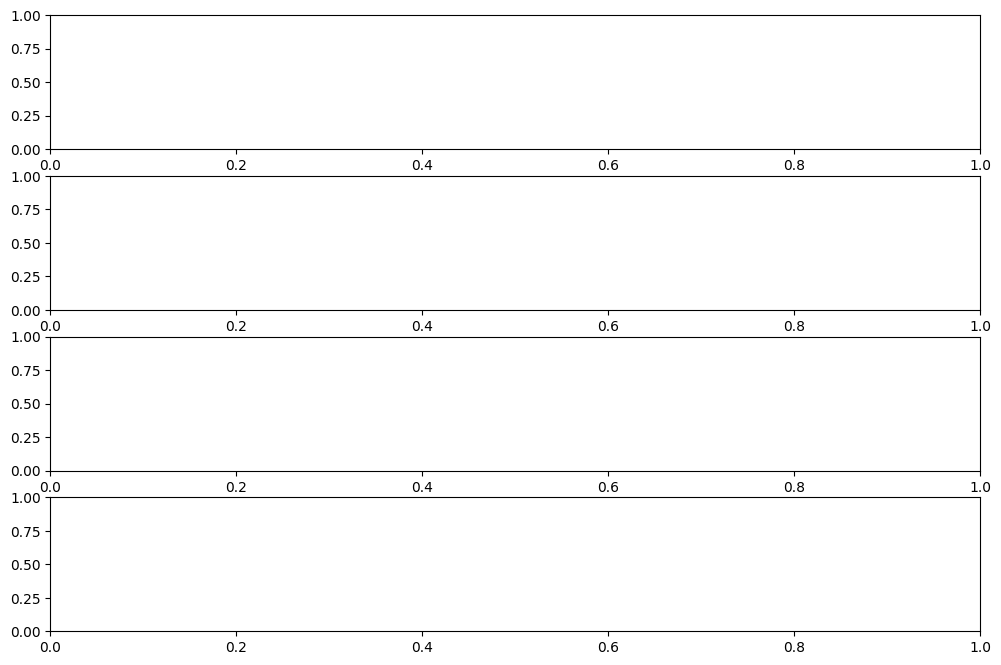

In [12]:
delays = [0.125 * i for i in range(4)]
plt.figure(figsize=(12, 8))
pp_times = []
dp_times = []
healthy_dp_time = None
for i, delay in enumerate(delays):
    ax = plt.subplot(4, 1, i + 1)
    path = f'./7B/ZB/{0 if delay == 0 else delay}/'
    # maxt, _ = parse_and_plot(ax, 4, 2, path, 1, 5, False)
    maxt=1
    with open(f"{path}/log.txt", 'r') as f:
        iters = re.findall(r"iteration \(ms\): (\d*\.\d+|\d+)", f.read())
    iter_times = np.array([float(iter) for iter in iters])
    if delay == 0:
        healthy_dp_time = (iter_times[1] - maxt)
    pp_times.append((healthy_dp_time + maxt) / 1000.0)
    dp_times.append(iter_times[1] / 1000.0)

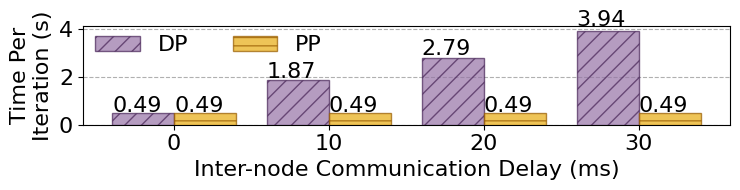

In [15]:
width = 0.4
COLORS = ['#9673A6', '#E7AB10', '#6C8EBF', '#B85450']
COLORS2 = ['#462356', '#975B00', '#1C3E6F', '#780400']
plt.figure(figsize=(7.5, 2))
plt.bar(np.arange(4), dp_times, width=width, label='DP', hatch='//', edgecolor=COLORS2[0], alpha=0.7, color=COLORS[0], zorder=100)
plt.bar(np.arange(4) + width, pp_times, width=width, label='PP', hatch='--', edgecolor=COLORS2[1], alpha=0.7, color=COLORS[1], zorder=100)
for i in range(4):
    plt.text(i - width / 2, dp_times[i] * 1.05, f'{dp_times[i]:.2f}', fontdict={"fontsize": 16})
    plt.text(i + width / 2, pp_times[i] * 1.05, f'{pp_times[i]:.2f}', fontdict={"fontsize": 16})
plt.xticks(np.arange(4) + width / 2, [str(10*i) for i in range(4)], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(0.4, 0.5), ncols=2, frameon=False, fontsize=16)
plt.xlabel("Inter-node Communication Delay (ms)", fontdict={"fontsize": 16})
plt.ylabel("Time Per\nIteration (s)", fontdict={'fontsize': 16})
plt.grid(linestyle='--', axis='y')
plt.tight_layout() 
plt.savefig("motivation_dp.pdf")

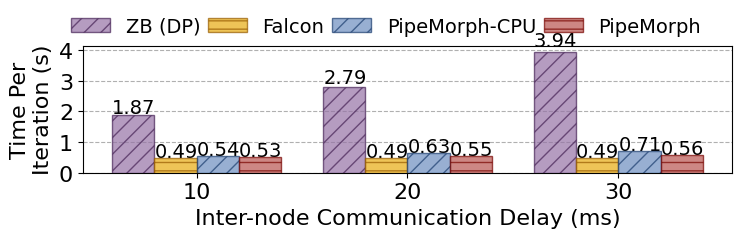

In [18]:
COLORS = ['#9673A6', '#E7AB10', '#6C8EBF', '#B85450']
COLORS2 = ['#462356', '#975B00', '#1C3E6F', '#780400']
old_data = []
for method in ['ZB-CPU', 'ZB-CPU-ReSchedule']:
    method_data = []
    for delay in [0.01*i for i in range(1, 4)]:
        with open(f"./7B/{method}/2_3/{delay}/log.txt") as f:
            iters = re.findall(r"iteration \(ms\): (\d*\.\d+|\d+)", f.read())
        iter_time = np.min(np.array([float(iter) for iter in iters])[8:]) / 1000.0
        method_data.append(iter_time)
    old_data.append(method_data)

width = 0.2
plt.figure(figsize=(7.5, 2.5))
plt.bar(np.arange(3), dp_times[1:], width=width, label='ZB (DP)', hatch='//', edgecolor=COLORS2[0], zorder=100, alpha=0.7, color=COLORS[0])
plt.bar(np.arange(3) + width, pp_times[1:], width=width, label='Falcon', hatch='--', edgecolor=COLORS2[1], zorder=100, alpha=0.7, color=COLORS[1])
plt.bar(np.arange(3) + 2 * width, old_data[0], width=width, label='PipeMorph-CPU', hatch='//', edgecolor=COLORS2[2], zorder=100, alpha=0.7, color=COLORS[2])
plt.bar(np.arange(3) + 3 * width, old_data[1], width=width, label='PipeMorph', hatch='--', edgecolor=COLORS2[3], zorder=100,alpha=0.7, color=COLORS[3])
for i in range(3):
    plt.text(i - width / 2, dp_times[i + 1] * 1.05, f'{dp_times[i + 1]:.2f}', fontdict={"fontsize": 14})
    plt.text(i + width / 2, pp_times[i + 1] * 1.05, f'{pp_times[i + 1]:.2f}', fontdict={"fontsize": 14})
    plt.text(i + 3 * width / 2, old_data[0][i] * 1.05, f'{old_data[0][i]:.2f}', fontdict={"fontsize": 14})
    plt.text(i + 5 * width / 2, old_data[1][i] * 1.05, f'{old_data[1][i]:.2f}', fontdict={"fontsize": 14})
plt.xticks(np.arange(3) + 3 * width / 2, [f'{i*10}' for i in range(1, 4)], fontsize=16)
plt.yticks(np.arange(5), [str(i) for i in np.arange(5)], fontsize=16)
plt.xlabel("Inter-node Communication Delay (ms)", fontdict={"fontsize": 16})
plt.ylabel("Time Per\nIteration (s)", fontdict={'fontsize': 16})
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.52, 0.97), fontsize=14, ncols=4, frameon=False, columnspacing=0.4)
plt.tight_layout(pad=1.0, rect=(0, 0, 1, 0.9))
plt.grid(linestyle='--', axis='y')
plt.savefig("DPnew.pdf")